## Detection of the Sun Center through Polarimetric Observations

By Alessandro Liberatore (alessandro.liberatore@inaf.it)

[This script was last tested and confirmed to run correctly on August 5, 2025]

---

In both coronagraphic and total solar eclipse observations, the solar disk is not directly visible. Blocking direct light from the photosphere is essential to observe the solar atmosphere, which is thousands of times dimmer than the solar disk. This lack of direct observation of the solar disk introduces uncertainty in determining the Sun’s center behind the occulter or the Moon. 

A common approach for detecting the Sun’s center is based on astrometry, which measures the precise positions of the Sun, looking at the position and movements of other celestial bodies like stars and planets. Methods such as astrometry are applicable only when stars are present in the field of view, which is not always the case due to several limiting factors. For instance, a low signal-to-noise ratio may prevent the detection of background stars, especially in highly scattered or noisy observations. Similarly, a small field of view can reduce or completely exclude the presence of reference stars, making astrometric measurements unfeasible. Additional challenges include instrumental limitations, exposure time constraints, and the brightness of the observed target, which can overpower faint background sources. These factors collectively restrict the applicability of astrometric techniques in certain observational conditions, necessitating alternative methods for precise positional measurements. 

In this notebook, we present a novel method for determining the center of the solar disk using polarimetric observations of the solar corona. The polarized component of the solar corona (K-corona) is the brightest component of the solar corona. The K-corona is due to Thomson diffusion of photospheric radiation by free coronal electrons and results linearly polarized with a polarization angle tangent to the solar limb. In particular, we will make use of the Angle of Linear Polarization ($AoLP$) maps, defined as:

$$ AoLP = \frac{1}{2} \arctan{\left(\frac{U}{Q}\right)}$$

where $Q$ and $U$ are the second and third elements of the stokes vector $\mathbf{S} = [S_0, S_1, S_2] = [I , Q, U]$.

---

Python packages necessary to run the code:

In [1]:
%matplotlib ipympl
#%matplotlib notebook
#%matplotlib inline

import glob
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator

from sunpy.sun import constants as con
import sunpy.map
import sunpy_soar
from sunpy.net import Fido, attrs as a

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, PowerStretch

/Users/aliberatore/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Download Metis $AoLP$ map:

In [2]:
# Select the instrument (e.g., METIS)
instrument = a.Instrument("METIS")

# Set the time range of interest
time = a.Time("2022-03-24 00:00:00", "2022-03-24 02:00:00")

# Select the product
product_AoLP = a.soar.Product("metis-vl-pol-angle")

# Select the level (0, 1, 2)
level = a.Level(2)

# Show the available data
result_AoLP = Fido.search(instrument & time & product_AoLP & level)

print(f"{'#' * 20} AoLP {'#' * 20}\n{result_AoLP}")

#################### AoLP ####################
Results from 1 Provider:

4 Results from the SOARClient:

Instrument    Data product    ... Filesize             SOOP Name            
                              ...  Mbyte                                    
---------- ------------------ ... -------- ---------------------------------
     METIS metis-vl-pol-angle ...    12.64 L_FULL_HRES_HCAD_Coronal-Dynamics
     METIS metis-vl-pol-angle ...    12.64 L_FULL_HRES_HCAD_Coronal-Dynamics
     METIS metis-vl-pol-angle ...    12.64 L_FULL_HRES_HCAD_Coronal-Dynamics
     METIS metis-vl-pol-angle ...    12.64 L_FULL_HRES_HCAD_Coronal-Dynamics




In [3]:
downloaded_AoLP = Fido.fetch(result_AoLP)
print(f"{'#' * 20} AoLP {'#' * 20}\n{downloaded_AoLP}")

all_data = sorted(downloaded_AoLP)
print("Number of images:", len(all_data))

Files Downloaded:   0%|          | 0/4 [00:00<?, ?file/s]

#################### AoLP ####################
['/Users/aliberatore/sunpy/data/solo_L2_metis-vl-pol-angle_20220324T000101_V01.fits', '/Users/aliberatore/sunpy/data/solo_L2_metis-vl-pol-angle_20220324T003101_V01.fits', '/Users/aliberatore/sunpy/data/solo_L2_metis-vl-pol-angle_20220324T010101_V01.fits', '/Users/aliberatore/sunpy/data/solo_L2_metis-vl-pol-angle_20220324T013101_V01.fits']
Number of images: 4


Plot images

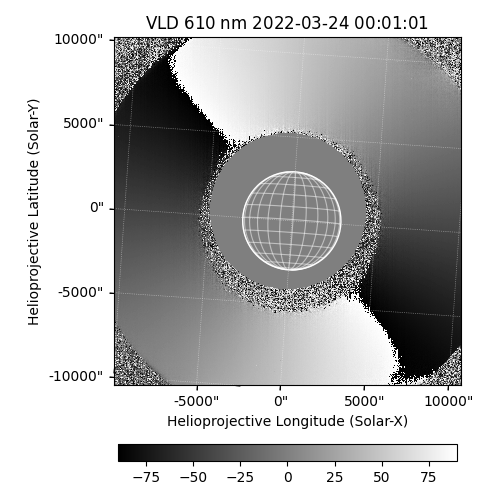

In [4]:
i = 0          # image you want to plot (0 <= i < Number of images)
extension = 0  # fits extension you want to plot

AoLP_map = sunpy.map.Map(all_data[i])[extension]
AoLP_map.plot_settings['norm'] = ImageNormalize(vmin=-90, vmax=+90)

fig = plt.figure(figsize=(5, 5))

axes = [fig.add_subplot(1, 1, i+1, projection=m.wcs) for i, m in enumerate([AoLP_map])]

for ax, m in zip(axes, [AoLP_map]):
    im = m.plot(axes=ax)
    m.draw_limb(axes=ax)
    m.draw_grid(axes=ax)
    plt.colorbar(im, ax=ax, orientation='horizontal', fraction=0.04, pad=0.14)
    
plt.tight_layout()
plt.show()

The method presented in this notebook for determining the center of the Sun behind the occulter requires selecting two angles ($\alpha$ and $\beta$) and drawing two lines. Each line passes through one of the angles and its opposite angle (i.e., one line passes through $\alpha$ and $\alpha + 180^\circ$, and the other one between $\beta$ and $\beta + 180^\circ$). Once these two lines are obtained, their intersection must be determined. This intersection will indicate the position of the Sun's center. 

The following function, returns the intersection point (x, y) given the endpoints of the two lines: 

In [5]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('Lines do not intersect!')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    
    return x, y

To determine the value of the Sun's center to compare with the actual value reported in the FITS file header, we will iterate the procedure (i.e., angles selection and evaluation of the intersection of the lines passing through them) for various angles $\varphi$, and then compute the average. 

Since we are dealing with two lines, we have a range that can vary between 0 and 180 degrees for each line at most.

The core of the code consist of evaluating the endpoints of the lines required to execute `line_intersection()`. The position of the endpoints are obtained as the average of the position of all pixels in regions of interest (ROIs).

Each element of `dist_vec` is a distance between the real Sun Center (from FITS header) and the obtained one (from the lines intersection) at fixed $\varphi$ for a single $AoLP$ map. 

The average of all the element of `dist_vec` (i.e., an average distance obtained considering all the $\varphi$) is an element of vector `dist_vecALL`. Thus, `dist_vecALL` contains a number of elements equal to the number of $AoLP$ maps considered.

In [6]:
# Limits on the considered angular range
phi_istart, phi_istop, phi_istep = 30., 61., 1. # [deg]    -default angular range-
rho_limIN, rho_limOUT = 30., 100.               # [pixels] -default radial range-

# Flags
NBIN_val = 2                     # set the NBIN values of the images you want to consider (for Metis: NBIN_val = 1, 2, 4)
plotFig, savePNG = False, False  # set True if you want to see plots or save PNG (plotFig must be set 'True' as well in this case)
verbose = False                  # set True if you wish to print
excluded_values = []

if plotFig:
    plt.ion()
else:
    plt.ioff()

In [7]:
# List containing the distances between the real Sun center and the ones obtained from the lines' intersection ("polarimetric Sun center" hereafter) for different Sun-Spacecraft distances (in Astronomical Units)
dist_vecALL = []
dist_vecALL_best = []
sigma_vecALL = []
sigma_vecALL_best = []
AUvec = []

# List containing information on the ROIs (e.g., number of pixels and width)
LEN_ROIsector_vec_avg = []
mean_std_ROI_vec = []
mean_phi_iocen_vec_TRTLBLBR_vec = []
std_phi_iocen_vec_TRTLBLBR_vec = []

# Lists containing the average of the AoLP ROI to evaluate the error on the angle
AoLP_vs_radial_img = []
AoLP_vs_radial_img_fig = []
AoLP_vs_radial_vecsimg = []
AoLP_vs_radial_vecsimg_fig = []

# Values set in the cycles
delta_phi_min = 0.1 # after several tests, a deltaPhi of 0.1 is the minimum value to ensure a non-empty array in the dataset considered

# Image reading
AoLPimg_vec = [fits.open(all_data[i])[0] for i in range(len(all_data))]
phi_i_vec = [phi_i for phi_i in np.arange(phi_istart, phi_istop, phi_istep)]  # list of considered phi

# Cycle on the list of considered images (as test, set: 271, 272)
from_AoLPimg = 0               # first image to consider
to_AoLPimg = len(AoLPimg_vec)  # last image to consider

for AoLPimg in range(from_AoLPimg, to_AoLPimg):
    
    print("Img n.:", AoLPimg, "/", len(AoLPimg_vec)-1)
    
    if AoLPimg not in excluded_values:    

        # Initialization of used list ##############
        
        AoLP_vs_radial_ROIsector_differentrotation_AVG_vec = []
        AoLP_vs_radial_ROIsector_differentrotation_AVG_vec_min = []
        AoLP_vs_radial_ROIsector_differentrotation_AVG_vec_max = []
        AoLP_vs_radial_ROIsector_differentrotation_AVG_vec_mean = []
        x_inters_vec = []
        y_inters_vec = []
        dist_vec = []
        LEN_ROIsector_vec = []
        std_ROI_vec = []
        phi_iocen_vec_TRTLBLBR_vec = []
        
        # ##########################################     
        
        
        
        # Image under consideration ################
        
        hdu_AoLP = AoLPimg_vec[AoLPimg]
        
        # Instrument features **********************
        dataMap_deg = True                            # set 'True' if the data maps are in degree. Set 'False' if in radians.
        Number_of_bin = hdu_AoLP.header['NBIN1']      # considered binning factor (axis 1 = axis 2)
        imageID = "SESS_NUM: {0} | FILENAME: {1}".format(hdu_AoLP.header['SESS_NUM'], hdu_AoLP.header['FILENAME'])  # ID of the considered image
        imageDATE = hdu_AoLP.header['DATE-AVG']       # time of observation               
        pixel_scale_arcsec_axis1 = hdu_AoLP.header['CDELT1']  # pixel scale along axis 1 [arcsec]   
        pixel_scale_arcsec_axis2 = hdu_AoLP.header['CDELT2']  # pixel scale along axis 2 [arcsec]   
        imageINFOV = hdu_AoLP.header['INN_FOV']       # inner FoV [deg]
        imageOUTFOV = hdu_AoLP.header['OUT_FOV']      # outer FoV [deg]
        dim_axis1 = hdu_AoLP.header['PXEND1']         # last pixel read out in dimension 1 (i.e., dim of axis 1) [pixel]
        dim_axis2 = hdu_AoLP.header['PXEND2']         # last pixel read out in dimension 1 (i.e., dim of axis 2) [pixel]
        rsun_arcsec = hdu_AoLP.header['RSUN_ARC']     # solar radius in arcsecond
        image_IOcen = (hdu_AoLP.header['IO_XCEN'], hdu_AoLP.header['IO_YCEN'])     # Internal Occulter center coordinate [pixel]
        image_SUNcen = (hdu_AoLP.header['SUN_XCEN'], hdu_AoLP.header['SUN_YCEN'])  # Sun center coordinate [pixel]
        image_CROTA = hdu_AoLP.header['CROTA']        # rotation angle [deg]
        shift_AoLP = 49                               # angle wrt reference axis
        
        if shift_AoLP <= 0:
            lim360 = 360+shift_AoLP
        else:
            lim360 = shift_AoLP
        # ******************************************

        if dataMap_deg:
            my_map = sunpy.map.Map(hdu_AoLP.data, hdu_AoLP.header)
        else:
            hdu_AoLP.data = hdu_AoLP.data*180/np.pi
            my_map = sunpy.map.Map(hdu_AoLP.data, hdu_AoLP.header)
 
        # ##########################################     
        
        
        if Number_of_bin == NBIN_val:
            
            # Image Name, WCS and Obs. time ********
            if verbose:
                print(imageID)
            wcs_Metis = WCS(hdu_AoLP.header)
            DATE_AVG_AoLP = imageDATE
            # **************************************     
            
            
            
            # Instrument Field of View (FoV) *******
            fov1 = imageINFOV*3600/pixel_scale_arcsec_axis1  # internal FoV [pixel]
            fov2 = imageOUTFOV*3600/pixel_scale_arcsec_axis2  # external FoV [pixel]
            # **************************************     
            
            
            
            # Polar Maps and Masks *****************
            x = np.arange(dim_axis1)
            y = np.arange(dim_axis2)
            xx, yy = np.meshgrid(x, y, sparse = False)
            rho_iocen = np.sqrt((xx-image_IOcen[0])**2 + (yy-image_IOcen[1])**2)                       # Map of distance from IO center [pixel]
            phi_iocen = (np.arctan2((yy-image_IOcen[1]), (xx-image_IOcen[0]))*(180/np.pi)+360)%360     # Map of angle from IO center [deg]
            phi_suncen = (np.arctan2((yy-image_SUNcen[1]), (xx-image_SUNcen[0]))*(180/np.pi)+360)%360  # Map of angle from Sun center [deg]
            
            hdu_AoLP.data[rho_iocen < fov1] = 0.         # Internal Occulter mask
            hdu_AoLP.data[rho_iocen > fov2-10] = np.nan  # Field Stop mask
            
            Rsun_m = con.constants['radius'].value              # Solar Radius in meters
            R_Sun_pixel = rsun_arcsec/pixel_scale_arcsec_axis1  # Solar Radius in pixel
            if pixel_scale_arcsec_axis1 == pixel_scale_arcsec_axis2:
                platescale = pixel_scale_arcsec_axis1                           # Instrument platescale [arcsec/pixel]
            else:
                platescale = pixel_scale_arcsec_axis1                           # Instrument platescale [arcsec/pixel]
                print("ATTENTION! DIFFERENT PLATESCALES ALONG X AND Y!  -  TBD. Same platescale is considered.")
            R_Sun_arcsec = R_Sun_pixel * platescale                             # Solar radius in arcsec
            AU_m = con.constants['mean distance'].value                         # Astronomical Unit in meters
            
            distance = Rsun_m/np.tan(rsun_arcsec/60/60*np.pi/180) / AU_m        # Sun-Spacecraft distance in Astronomical Units [AU]
            if verbose:
                print("Sun-S/C distance:", distance)
            AUvec.append(distance)
            
            rho_IO_Rsun = np.sqrt(((xx-image_IOcen[0]) * platescale / R_Sun_arcsec)**2 + ((yy-image_IOcen[1]) * platescale / R_Sun_arcsec)**2)     # Map of distance from IO center [R_sun]
            rho_Sun_Rsun = np.sqrt(((xx-image_SUNcen[0]) * platescale / R_Sun_arcsec)**2 + ((yy-image_SUNcen[1]) * platescale / R_Sun_arcsec)**2)  # Map of distance from Sun center [R_sun]
            # **************************************
            
            
            
            # About angle tangentiality ************
            height, width = my_map.data.shape[0], my_map.data.shape[1]
            x, y = np.meshgrid(np.arange(width), np.arange(height))
            sun_y = image_SUNcen[1]
            sun_x = image_SUNcen[0]
            rad_angle = np.arctan2(y - sun_y, x - sun_x)
            rad_angle = rad_angle % np.pi
            tan_angle = rad_angle - 0.5*np.pi
            tan_angle_deg_rotated = sunpy.map.Map(tan_angle*(180/np.pi), hdu_AoLP.header)
            
            #if plotFig:
            if False:
                fig = plt.figure(figsize=(14., 2.5))
                
                ax0 = fig.add_subplot(1, 3, 1, projection = tan_angle_deg_rotated)
                #ax0.imshow(tan_angle_deg_rotated, cmap = "jet", origin='lower', vmin = 0, vmax = 360)
                tan_angle_deg_rotated.plot(cmap = "jet", vmin = 0, vmax = 360)
                tan_angle_deg_rotated.draw_limb()
                tan_angle_deg_rotated.draw_grid()
                lon, lat = ax0.coords
                lon.set_major_formatter('d.dd')
                lat.set_major_formatter('d.dd')

                ax1 = fig.add_subplot(1, 3, 2, projection = my_map)
                my_map.plot(cmap = "jet", vmin = -90, vmax = 90)
                my_map.draw_limb()
                my_map.draw_grid()
                lon, lat = ax1.coords
                lon.set_major_formatter('d.dd')
                lat.set_major_formatter('d.dd')
                ax1.coords.grid(True, color = 'white', ls = 'dotted', alpha = 0.5)
                plt.colorbar(label = "AoLP [deg]", shrink = 1.00, pad = 0.07)
            
            img_difference = hdu_AoLP.data-tan_angle_deg_rotated.data
            img_difference[img_difference>90] = img_difference[img_difference>90]-180
            img_difference[img_difference<-90] = img_difference[img_difference<-90]+180
            
            img_difference -= shift_AoLP
            hdu_AoLPdata_vs_theta_map = sunpy.map.Map(img_difference, hdu_AoLP.header)            
            
            #if plotFig:
            if False:
                ax2 = fig.add_subplot(1, 3, 3, projection = my_map)
                hdu_AoLPdata_vs_theta_map.plot(cmap = "jet", vmin = 0, vmax = 10)
                hdu_AoLPdata_vs_theta_map.draw_limb()
                hdu_AoLPdata_vs_theta_map.draw_grid()
                lon, lat = ax2.coords
                lon.set_major_formatter('d.dd')
                lat.set_major_formatter('d.dd')
                ax2.coords.grid(True, color = 'white', ls = 'dotted', alpha = 0.5)
                plt.colorbar(label = r"(AoLP-$\theta$)-90 [deg]", shrink = 1.00, pad = 0.07)
            
            #if plotFig:
            if False:
                img_difference[rho_iocen < fov1] = np.nan  # Internal Occulter mask
    
                angles = np.array(img_difference).flatten()
                mean = np.nanmean(angles)
                
                fig, (ax_img, ax_hist) = plt.subplots(1, 2, figsize=(10, 4), dpi = 100, gridspec_kw={'width_ratios': [1, 1.2]})
                
                im = ax_img.imshow(img_difference, origin = "lower", cmap='viridis', vmin=-5, vmax=5)
                ax_img.set_title("Map")
                ax_img.axis('on')
                ax_img.set_xlabel("x [pixel]")
                ax_img.set_ylabel("y [pixel]")
                fig.colorbar(im, ax=ax_img, fraction=0.046, pad=0.04, label="Dev. from tan. [deg]")
                
                
                # n = len(angles)
                # nbin = int(np.ceil(np.log2(n) + 1))
                nbin = 1000
                ax_hist.hist(angles, bins=nbin, range=(-30, 30), edgecolor='black', color='cornflowerblue')
                ax_hist.set_title("Hist")
                ax_hist.set_xlabel(r"$\varphi$ [deg]")
                ax_hist.set_ylabel("Counts [#]")
                ax_hist.axvline(mean, color='red', linestyle='--', label=f"Mean = {mean:.2f}°")
                ax_hist.legend()
                
                freq, bin_edges = np.histogram(angles, bins=nbin, range=(0, 90))
                index_peak = np.argmax(freq)
                center_peack = 0.5 * (bin_edges[index_peak] + bin_edges[index_peak + 1])
                
                print(f"Hist Mean: {mean:.2f}°")
                print(f"Hist Peak: {center_peack:.2f}° with {freq[index_peak]} pixels")
                
                plt.tight_layout()
 
            # if savePNG:
            if False:
                plt.savefig(path+"/output/IMG{0}_MetisSunDist_{1:.3f}AU_ObsTime_{2:}.png".format(AoLPimg, distance, DATE_AVG_AoLP))
            # **************************************
            
            
            
            # Absolute value of AoLP maps **********
            hdu_AoLP.data = np.abs(hdu_AoLP.data)
            # **************************************
            
            
            
            # Cycle on the radial distances ********
            for r_i in np.arange(1, 2, 1):
                
                # Image reading
                AoLPimg_vec = [fits.open(all_data[i])[0] for i in range(len(all_data))]
                
                # Cycle on the considered angles
                for phi_i in np.arange(phi_istart, phi_istop, phi_istep):
                        
                    # Region of Interest (ROI) -------------
                    
                    # Radial ROI
                    ROIrho = np.logical_and(rho_iocen > fov1+rho_limIN, rho_iocen < fov1+rho_limOUT*r_i)
                    
                    # Angular ROI
                    ROIphi = np.logical_and(hdu_AoLP.data >= phi_i-delta_phi_min, hdu_AoLP.data <= phi_i+delta_phi_min)  
                    
                    # Total ROI (i.e., Radial + Angular)
                    ROI = np.logical_and(ROIrho, ROIphi)
                    hdu_AoLP.data = np.where(ROI, np.nan, hdu_AoLP.data)
                    
                    # Top-Right ROI 
                    ROI_sectorTR = np.logical_and(ROI, np.logical_and(phi_iocen > 0+shift_AoLP, phi_iocen < 90+shift_AoLP))
                    AoLP_vs_radial_TR = hdu_AoLPdata_vs_theta_map.data[ROI_sectorTR]
                    
                    # Top-Left ROI 
                    ROI_sectorTL = np.logical_and(ROI, np.logical_and(phi_iocen > 90+shift_AoLP, phi_iocen < 180+shift_AoLP))
                    AoLP_vs_radial_TL = hdu_AoLPdata_vs_theta_map.data[ROI_sectorTL]
                    
                    # Bottom-Left ROI 
                    ROI_sectorBL = np.logical_and(ROI, np.logical_and(phi_iocen > 180+shift_AoLP, phi_iocen < 270+shift_AoLP))
                    AoLP_vs_radial_BL = hdu_AoLPdata_vs_theta_map.data[ROI_sectorBL]
                    
                    # Bottom-Right ROI 
                    ROI_sectorBR = np.logical_and(ROI, np.logical_or(phi_iocen > 270+shift_AoLP, phi_iocen < lim360))
                    AoLP_vs_radial_BR = hdu_AoLPdata_vs_theta_map.data[ROI_sectorBR]
                    
                    # Number of pixels considered (average of all ROIs)
                    LEN_ROIsector = (len(AoLP_vs_radial_TR)+len(AoLP_vs_radial_TL)+len(AoLP_vs_radial_BL)+len(AoLP_vs_radial_BR))/4
                    LEN_ROIsector_vec.append(LEN_ROIsector)
                    
                    if verbose:
                        print("Magenta:", np.mean(AoLP_vs_radial_TR))  # Average value of AoLP in ROI1
                        print("Cyan:", np.mean(AoLP_vs_radial_TL))     # Average value of AoLP in ROI2
                        print("Orange:", np.mean(AoLP_vs_radial_BL))   # Average value of AoLP in ROI3
                        print("Lime:", np.mean(AoLP_vs_radial_BR))     # Average value of AoLP in ROI4
                        print("LEN_ROIsector:", LEN_ROIsector)         # average number of pixels in the ROIs
                    
                    AoLP_vs_radial_ROIsector_AVG = (np.nanmean(AoLP_vs_radial_TR)+np.nanmean(AoLP_vs_radial_TL)+np.nanmean(AoLP_vs_radial_BL)+np.nanmean(AoLP_vs_radial_BR))/4
                    AoLP_vs_radial_norm_val = np.max([np.nanmean(AoLP_vs_radial_TR), np.nanmean(AoLP_vs_radial_TL), np.nanmean(AoLP_vs_radial_BL), np.nanmean(AoLP_vs_radial_BR)])
                    AoLP_vs_radial_ROIsector_differentrotation_AVG_vec.append(AoLP_vs_radial_norm_val)

                    if verbose:
                        print("Angle: {0}".format(phi_i), [np.nanmean(AoLP_vs_radial_TR), np.nanmean(AoLP_vs_radial_TL), np.nanmean(AoLP_vs_radial_BL), np.nanmean(AoLP_vs_radial_BR)])
                        print("AoLP_vs_radial_ROIsector average all colors:", AoLP_vs_radial_ROIsector_AVG)
                    # --------------------------------------
                    
                    
                    
                    # Plot AoLP map and intersection -------
                    my_map = sunpy.map.Map(hdu_AoLP.data, hdu_AoLP.header)            
                    considered_angles = [ROI]
                    
                    #plotFig = True                
                    if plotFig:
                        plt.figure(figsize = [7, 7], dpi = 250)
                        ax = plt.subplot(1, 1, 1, projection = my_map)
                    
                    x_vecTL, x_vecBL, x_vecTR, x_vecBR = [], [], [], []  # T, B, L, R = Top, Bottom, Left, Right
                    y_vecTL, y_vecBL, y_vecTR, y_vecBR = [], [], [], []  # T, B, L, R = Top, Bottom, Left, Right
                    phi_iocen_vec_TR, phi_iocen_vec_TL, phi_iocen_vec_BL, phi_iocen_vec_BR = [], [], [], []
                    
                    for i in range(len(considered_angles)):
                        index = np.where(considered_angles[i])
                        index_yx = zip(index[0], index[1])
                        
                        for y, x in index_yx:
                            # There is a shift of 45deg in the standard cartesian sectors due to the 45deg shift between polar angle and AoLP
                            if phi_iocen[y][x] > 0+shift_AoLP and phi_iocen[y][x] < 90+shift_AoLP:  # = phi_iocen > 0 and phi_iocen < 90
                                x_vecTR.append(x)
                                y_vecTR.append(y)
                                if plotFig:
                                    ax.plot(x, y, '.', color='magenta')
                                phi_iocen_vec_TR.append(phi_iocen[y][x])
                            elif phi_iocen[y][x] > 90+shift_AoLP and phi_iocen[y][x] < 180+shift_AoLP:  # = phi_iocen > 90 and phi_iocen < 180
                                x_vecTL.append(x)
                                y_vecTL.append(y)
                                if plotFig:
                                    ax.plot(x, y, '.', color='cyan')
                                phi_iocen_vec_TL.append(phi_iocen[y][x])
                            elif phi_iocen[y][x] > 180+shift_AoLP and phi_iocen[y][x] < 270+shift_AoLP:  # = phi_iocen > 180 and phi_iocen < 270
                                x_vecBL.append(x)
                                y_vecBL.append(y)
                                if plotFig:
                                    ax.plot(x, y, '.', color='orange')
                                phi_iocen_vec_BL.append(phi_iocen[y][x])
                            elif phi_iocen[y][x] > 270+shift_AoLP or phi_iocen[y][x] < lim360:  # = phi_iocen > 270 and phi_iocen < 360
                                x_vecBR.append(x)
                                y_vecBR.append(y)
                                if plotFig:
                                    ax.plot(x, y, '.', color='lime')
                                if phi_iocen[y][x] < shift_AoLP:
                                    phi_iocen_vec_BR.append(phi_iocen[y][x]+360)
                                else:
                                    phi_iocen_vec_BR.append(phi_iocen[y][x])
                            else:
                                sys.exit("ERROR")
                    
                    # ROIs' half-width
                    phi_iocen_vec_TR = np.max( [np.abs(np.mean(phi_iocen_vec_TR)-phi_iocen_vec_TR[i]) for i in range(len(phi_iocen_vec_TR))] )
                    phi_iocen_vec_TL = np.max( [np.abs(np.mean(phi_iocen_vec_TL)-phi_iocen_vec_TL[i]) for i in range(len(phi_iocen_vec_TL))] )
                    phi_iocen_vec_BL =  np.max( [np.abs(np.mean(phi_iocen_vec_BL)-phi_iocen_vec_BL[i]) for i in range(len(phi_iocen_vec_BL))] )
                    phi_iocen_vec_BR =  np.max( [np.abs(np.mean(phi_iocen_vec_BR)-phi_iocen_vec_BR[i]) for i in range(len(phi_iocen_vec_BR))] )
                    
                    if verbose:
                        print("phi_iocen_vec_TR:", phi_iocen_vec_TR)
                        print("phi_iocen_vec_TL:", phi_iocen_vec_TL)
                        print("phi_iocen_vec_BL:", phi_iocen_vec_BL)
                        print("phi_iocen_vec_BR:", phi_iocen_vec_BR)
                    
                    phi_iocen_vec_TRTLBLBR_vec.append(phi_iocen_vec_TR)
                    phi_iocen_vec_TRTLBLBR_vec.append(phi_iocen_vec_TL)
                    phi_iocen_vec_TRTLBLBR_vec.append(phi_iocen_vec_BL)
                    phi_iocen_vec_TRTLBLBR_vec.append(phi_iocen_vec_BR)
                        
                    # ROIs' deviation from tangentiality
                    AoLP_vs_radial_norm_val = np.mean([phi_iocen_vec_TR,phi_iocen_vec_BL,phi_iocen_vec_TL,phi_iocen_vec_BR])  # useful for tests; e.g., "[...] * np.mean([phi_iocen_vec_TR,phi_iocen_vec_BL,phi_iocen_vec_TL,phi_iocen_vec_BR])"
                    AoLP_vs_radial_norm_val_min = np.min([np.abs(np.nanmean(AoLP_vs_radial_TR)), np.abs(np.nanmean(AoLP_vs_radial_BL)), np.abs(np.nanmean(AoLP_vs_radial_TL)), np.abs(np.nanmean(AoLP_vs_radial_BR))])
                    AoLP_vs_radial_norm_val_max = np.max([np.abs(np.nanmean(AoLP_vs_radial_TR)), np.abs(np.nanmean(AoLP_vs_radial_BL)), np.abs(np.nanmean(AoLP_vs_radial_TL)), np.abs(np.nanmean(AoLP_vs_radial_BR))])
                    AoLP_vs_radial_norm_val_mean = np.mean([np.abs(np.nanmean(AoLP_vs_radial_TR)), np.abs(np.nanmean(AoLP_vs_radial_BL)), np.abs(np.nanmean(AoLP_vs_radial_TL)), np.abs(np.nanmean(AoLP_vs_radial_BR))])
                    
                    AoLP_vs_radial_ROIsector_differentrotation_AVG_vec.append(AoLP_vs_radial_norm_val)
                    AoLP_vs_radial_ROIsector_differentrotation_AVG_vec_min.append(AoLP_vs_radial_norm_val_min)
                    AoLP_vs_radial_ROIsector_differentrotation_AVG_vec_max.append(AoLP_vs_radial_norm_val_max)
                    AoLP_vs_radial_ROIsector_differentrotation_AVG_vec_mean.append(AoLP_vs_radial_norm_val_mean)
                            
                    # Average and standard deviation on the points in the ROIs
                    mean_x_vecTR, mean_y_vecTR = np.mean(x_vecTR), np.mean(y_vecTR)
                    mean_x_vecTL, mean_y_vecTL = np.mean(x_vecTL), np.mean(y_vecTL)
                    mean_x_vecBL, mean_y_vecBL = np.mean(x_vecBL), np.mean(y_vecBL)
                    mean_x_vecBR, mean_y_vecBR = np.mean(x_vecBR), np.mean(y_vecBR)
                    std_x_vecTR, std_y_vecTR = np.std(x_vecTR), np.std(y_vecTR)
                    std_x_vecTL, std_y_vecTL = np.std(x_vecTL), np.std(y_vecTL)
                    std_x_vecBL, std_y_vecBL = np.std(x_vecBL), np.std(y_vecBL)
                    std_x_vecBR, std_y_vecBR = np.std(x_vecBR), np.std(y_vecBR)
                    std_TR = np.sqrt(std_x_vecTR**2 + std_y_vecTR**2)
                    std_TL = np.sqrt(std_x_vecTL**2 + std_y_vecTL**2)
                    std_BL = np.sqrt(std_x_vecBL**2 + std_y_vecBL**2)
                    std_BR = np.sqrt(std_x_vecBR**2 + std_y_vecBR**2)
                    std_ROI = (std_TR+std_TL+std_BL+std_BR)/4
                    std_ROI_vec.append(std_ROI)
                    
                    if verbose:
                        print("***** len(std_ROI_vec):", len(std_ROI_vec))

                    # Intersection point
                    # Line 1
                    A = [mean_x_vecTL, mean_y_vecTL]
                    B = [mean_x_vecBR, mean_y_vecBR]
                    # Line 2
                    C = [mean_x_vecBL, mean_y_vecBL]
                    D = [mean_x_vecTR, mean_y_vecTR]
                    # Intersection of Line1 and Line 2
                    x_inters, y_inters = line_intersection((A, B), (C, D))
                    
                    # Distance between Sun centers (Astrometrical - Polarimetric)
                    dist = np.sqrt((image_SUNcen[0]-x_inters)**2 + (image_SUNcen[1]-y_inters)**2) 
                    dist_vec.append(dist)
                    #print("dist_vec:", dist_vec, "\n")

                    if verbose:
                        print("RealCenter[pixel]: (x, y) = ({0}, {1})".format(image_SUNcen[0], image_SUNcen[1]))
                        print("MyCenter[pixel]:   (x, y) = ({0}, {1})".format(x_inters, y_inters))
                        print("Difference: {0:.2f} pixel = {1:.2f} arcsec = {2:.2f} min = {3:.2f} deg".format(dist, dist*platescale, dist*platescale/60, dist*platescale/60/60))
                        print("Offests:\n", dist_vec)
                        
                    if plotFig:
                                                
                        # Draw avg points P_i
                        ax.plot(mean_x_vecTR, mean_y_vecTR, '.', color='black')  # P1
                        ax.plot(mean_x_vecTL, mean_y_vecTL, '.', color='black')  # P2
                        ax.plot(mean_x_vecBL, mean_y_vecBL, '.', color='black')  # P3
                        ax.plot(mean_x_vecBR, mean_y_vecBR, '.', color='black')  # P4
        
                        # Draw lines
                        ax.plot([mean_x_vecTL, mean_x_vecBR], [mean_y_vecTL, mean_y_vecBR], color='green')  # Line 1 
                        ax.plot([mean_x_vecBL, mean_x_vecTR], [mean_y_vecBL, mean_y_vecTR], color='green')  # Line 2
        
                        # Draw Sun centers and Internal Occulter points
                        ax.plot(x_inters, y_inters, '.', color='yellow')                                      # Polarimetric Sun center
                        ax.plot(image_SUNcen[0], image_SUNcen[1], '.', color='cyan')  # Astrometric Sun center
                        ax.plot(image_IOcen[0], image_IOcen[1], '.', color='red')     # Internal Occulter center
        
                        # Plot cosmetic
                        lon, lat = ax.coords
                        lon.set_major_formatter('d.dd')
                        lat.set_major_formatter('d.dd')
                        ax.coords.grid(True, color = 'white', ls = 'dotted', alpha = 0.5)
                        my_map.plot(cmap = "jet", vmin = 0, vmax = 90)
                        #hdu_AoLPdata_vs_theta_map.plot(cmap = "jet", vmin = 0, vmax = 10)
                        plt.colorbar(label = "|AoLP| [deg]", shrink = 1.00, pad = 0.07)
                        my_map.draw_limb()
                        my_map.draw_grid()
                        
                        plt.xlabel('Helioprojective Longitude (Solar-X)')
                        plt.ylabel('Helioprojective Latitude (Solar-Y)')
                        
                        title_name = "ObsTime: {0:} | AU: {1:.2f}\nOffset: ({2:.2f} $\pm$ {3:.2f}) pix\n".format(DATE_AVG_AoLP, distance, np.nanmean(dist_vec), np.nanstd(dist_vec))
                        plt.title(title_name, y = 0.96, fontsize = 15)

                        # Save images
                        if savePNG:
                        #if True:
                            # plt.savefig(path+"/output/Fig{0}_MetisSunDist_{1:.3f}AU_ObsTime_{2:}_SCsDist_{3:.2f}pix.png".format(AoLPimg, distance, DATE_AVG_AoLP, np.nanmean(dist_vec)))
                            plt.savefig(path+"/output/Fig{0}_Phi{1}_MetisSunDist_{2:.3f}AU_ObsTime_{3:}_TR{4:.2f}_TL{5:.2f}_BL{6:.2f}_BR{7:.2f}.png".format(AoLPimg, phi_i, distance, DATE_AVG_AoLP, np.nanmean(AoLP_vs_radial_TR), np.nanmean(AoLP_vs_radial_TL), np.nanmean(AoLP_vs_radial_BL), np.nanmean(AoLP_vs_radial_BR)))
                    
                        #plotFig = False                
                    x_inters_vec.append(x_inters)
                    y_inters_vec.append(y_inters)
                    # --------------------------------------
        
            # **************************************
            
            
            
            # About lists on the ROI features ******               
            
            # ROIs lists
            if len(LEN_ROIsector_vec) == 0:
                LEN_ROIsector_vec_avg.append(np.nan)
            else:
                LEN_ROIsector_vec_avg.append(np.mean(LEN_ROIsector_vec))
            
            mean_std_ROI_vec.append(np.mean(std_ROI_vec))
            mean_phi_iocen_vec_TRTLBLBR_vec.append(np.mean(phi_iocen_vec_TRTLBLBR_vec))
            std_phi_iocen_vec_TRTLBLBR_vec.append(np.std(phi_iocen_vec_TRTLBLBR_vec))
            if verbose:
                print("----- len(mean_std_ROI_vec):", len(mean_std_ROI_vec))
                print("----- len(mean_phi_iocen_vec_TRTLBLBR_vec):", len(mean_phi_iocen_vec_TRTLBLBR_vec))
            
            if verbose:
                print("AoLP_vs_radial_ROIsector_differentrotation_AVG_vec:", AoLP_vs_radial_ROIsector_differentrotation_AVG_vec)
            
            AoLP_vs_radial_vecsimg.append(AoLP_vs_radial_ROIsector_differentrotation_AVG_vec)  # i.e., a list of the following lists: [max value among the four ROIs, for each angle] per considered image
            AoLP_vs_radial_img.append(np.nanmean(AoLP_vs_radial_ROIsector_differentrotation_AVG_vec))  # i.e., the following list: [average of [max value among the four ROIs, for each angle], per considered image]
            
            if verbose:
                print("AoLP_vs_radial_vecsimg:", AoLP_vs_radial_vecsimg)
                print("Len(AoLP_vs_radial_vecsimg):", len(AoLP_vs_radial_vecsimg))
                print("Len(AoLP_vs_radial_vecsimg[0]):", len(AoLP_vs_radial_vecsimg[0]))
                print("AoLP_vs_radial_img:", AoLP_vs_radial_img)
            
            # Smooting for plot
            window = 3
            dist_vec = np.convolve(np.ravel(dist_vec), np.ones(window)/window, mode='same')
                
            AoLP_vs_radial_ROIsector_differentrotation_AVG_vec = [1-(AoLP_vs_radial_ROIsector_differentrotation_AVG_vec_mean[i]/np.max(AoLP_vs_radial_ROIsector_differentrotation_AVG_vec_mean)) for i in range(len(AoLP_vs_radial_ROIsector_differentrotation_AVG_vec_min))]
            if len(AoLP_vs_radial_ROIsector_differentrotation_AVG_vec) > 0:
                AoLP_vs_radial_ROIsector_differentrotation_AVG_vec = np.convolve(np.ravel(AoLP_vs_radial_ROIsector_differentrotation_AVG_vec), np.ones(window)/window, mode='same')
            
            if verbose:
                print("phi_i_vec:", phi_i_vec)
                print("dist_vec:", dist_vec)
                print("AoLP_vs_radial_ROIsector_differentrotation_AVG_vec:", AoLP_vs_radial_ROIsector_differentrotation_AVG_vec)

            # Best area selection
            A = AoLP_vs_radial_ROIsector_differentrotation_AVG_vec  # list of TQI
            B = phi_i_vec                                           # list of considered angles
            C = dist_vec                                            # list of all offsets in phi_i_vec range
            
            # Find the highest "N values" in A
            N = 1
            top_indices = sorted(range(len(A)), key=lambda i: A[i], reverse=True)[:N]
            
            # Sort the indexes according to the original order
            top_indices_sorted = sorted(top_indices)
            
            # Extract the corresponding B values
            B_top_original_order = [B[i] for i in top_indices_sorted]   # new angles to consider
            
            # Extract the corresponding C values
            C_top_original_order = [C[i] for i in top_indices_sorted]   # offsets if considering only top_indices

            if verbose:
                print("top_indices (N = {0}):".format(N), top_indices)
                print("top_indices_sorted:", top_indices_sorted)
                print("B_top_original_order:", B_top_original_order)
                print("C_top_original_order:", C_top_original_order)
                
            DeltaMax = np.max(AoLP_vs_radial_ROIsector_differentrotation_AVG_vec_max)-np.min(AoLP_vs_radial_ROIsector_differentrotation_AVG_vec_max)
            DeltaMin = np.max(AoLP_vs_radial_ROIsector_differentrotation_AVG_vec_min)-np.min(AoLP_vs_radial_ROIsector_differentrotation_AVG_vec_min)
            if verbose:
                print("AoLPimg", AoLPimg)
                print("DeltaMax", DeltaMax)
                print("DeltaMin", DeltaMin)
            
            if plotFig:
                fig, ax1 = plt.subplots(figsize = [5.5, 3.5], dpi = 100)
                ax1.axvspan(phi_istart, phi_istop, color='orange', alpha=0.3, label=f'Area tra x={phi_istart} e x={phi_istop}')
                ax2 = ax1.twinx()
                
                line1, = ax1.plot(phi_i_vec, dist_vec, ".-", color = "blue", label = "Offset")
                line2, = ax2.plot(phi_i_vec, AoLP_vs_radial_ROIsector_differentrotation_AVG_vec, ".-", color = "red", label = r"Tangency Quality Index")
                
                ax1.set_xlim(0, 90)
                ax1.set_xlabel(r"$\vartheta_i$ [deg]")
                ax1.tick_params(axis = 'x', top = True, labeltop = False, direction = 'in')
                
                ax1.set_ylabel("Offset [pix]", color = 'blue')
                ax1.tick_params(axis = 'y', direction = 'in', colors = "blue")
                ax2.spines['left'].set_color('blue')
                ax2.spines['left'].set_linewidth(1.5)
                
                ax2.set_ylabel(r"TQI = $1 - |\Delta\Psi|/|\Delta\Psi|_{Max}$", color='red')
                ax2.tick_params(axis = 'both', direction = 'in', colors = "red")
                ax2.spines['right'].set_color('red')
                ax2.spines['right'].set_linewidth(1.5)
                
                lines = [line1, line2]
                labels = [line.get_label() for line in lines]
                ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False, fontsize=9)
                ax1.grid(True, linestyle = ':', alpha = 0.5)
    
                # Plot a line for each considered angle
                for x in B_top_original_order:
                    ax1.axvline(x=x, color='green', alpha=0.5, linestyle='--', linewidth=1)
            
                plt.tight_layout()
                if savePNG:
                    plt.savefig(path+"/output/TQI_Fig{0}_MetisSunDist_{1:.3f}AU_ObsTime_{2:}.png".format(AoLPimg, distance, DATE_AVG_AoLP))

            # List of offsets and associated standard deviation
            dist_vecALL.append(np.nanmean(dist_vec))
            dist_vecALL_best.append(np.nanmean(C_top_original_order))
            sigma_vecALL.append(np.nanstd(dist_vec))
            sigma_vecALL_best.append(np.nanstd(C_top_original_order))
            if verbose:
                print("dist_vecALL:", dist_vecALL)
                print("dist_vecALL_best:", dist_vecALL_best)
                print("sigma_vecALL:", sigma_vecALL)
                print("sigma_vecALL_best:", sigma_vecALL_best)
            # **************************************
        
        # ##########################################     

AUvec = [round(num, 6) for num in AUvec]  # To approx the Sun-Spacecraft distance to the 6th digits (comment this line for the full number)
phi_i_vec = [phi_i for phi_i in np.arange(phi_istart, phi_istop, phi_istep)]  # list of considered phi

plt.ion()

Img n.: 0 / 3


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-BEG to 59662.000709 from DATE-BEG.
Set MJD-AVG to 59662.010687 from DATE-AVG.
Set MJD-END to 59662.020664 from DATE-END'. [astropy.wcs.wcs]


Img n.: 1 / 3


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-BEG to 59662.021542 from DATE-BEG.
Set MJD-AVG to 59662.031520 from DATE-AVG.
Set MJD-END to 59662.041498 from DATE-END'. [astropy.wcs.wcs]


Img n.: 2 / 3


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-BEG to 59662.042376 from DATE-BEG.
Set MJD-AVG to 59662.052353 from DATE-AVG.
Set MJD-END to 59662.062331 from DATE-END'. [astropy.wcs.wcs]


Img n.: 3 / 3


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-BEG to 59662.063209 from DATE-BEG.
Set MJD-AVG to 59662.073187 from DATE-AVG.
Set MJD-END to 59662.083164 from DATE-END'. [astropy.wcs.wcs]


In [8]:
# Offsets values (i.e., distances between Astrometrical Sun center and Polarimetric Sun center) for all images
print("Number of considered images:", np.count_nonzero(~np.isnan(dist_vecALL)))
# Offsets
print("Offsets =", dist_vecALL)
# Average
print("Average offset: ({0:.2f} +/- {1:.2f}) pixels".format(np.mean(dist_vecALL[:]), np.mean(sigma_vecALL[:])))
print("[ Average best offset: {0:.2f} pixels ]".format(np.mean(dist_vecALL_best[:])))

# Distances in Solar Radii
dist_ROI_Rsun = []

for i in AUvec:
    
    d = i * AU_m/Rsun_m  # Sun-S/C distance [Rsun]
    theta = (1.6 + ((((rho_limIN + rho_limOUT)/2)*20.276)/3600)) * np.pi/180  # FoV [rad] = inner FoV + avg. ROI distance
    # theta = ((((rho_limIN + rho_limOUT)/2)*20.276)/3600) * np.pi/180        # FoV [rad] = avg. ROI distance
    s = d * np.tan(theta)  # Linear FoV [R_Sun]
    
    dist_ROI_Rsun.append(s)

Number of considered images: 4
Offsets = [2.0260941596947513, 2.0687986775721336, 1.9749479511235446, 1.9831566032807038]
Average offset: (2.01 +/- 1.22) pixels
[ Average best offset: 0.81 pixels ]


---